In [272]:
%matplotlib inline
%load_ext cython
%load_ext line_profiler

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [273]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
from skimage.feature import local_binary_pattern

In [274]:
def cropFace(image):
    faceClassifier = cv2.CascadeClassifier('./haarcascade/haarcascade_frontalface_alt.xml')
    faces = faceClassifier.detectMultiScale(image)
    #get first face coordinates
    xFace, yFace, wFace, hFace = faces[0]
    croppedFace = image[yFace:yFace+hFace, xFace:xFace+wFace]
    return croppedFace

In [288]:
def preprocess(image):
    image2 = cv2.equalizeHist(image)
    image2 = cv2.bilateralFilter(image2, 10, 100, 100)
    return image2

In [300]:
def kirsch(image):
    S = np.matrix([[ 5,  5,  5],
                   [-3,  0, -3],
                   [-3, -3, -3]
                  ])
    SE = np.matrix([[ 5,  5, -3],
                    [ 5,  0, -3],
                    [-3, -3, -3]
                   ])
    E = np.matrix([[5, -3, -3],
                   [5,  0, -3],
                   [5, -3, -3]
                  ])
    NE = np.matrix([[-3, -3, -3],
                    [ 5,  0, -3],
                    [ 5,  5, -3]
                   ])
    N = np.matrix([[-3, -3, -3],
                   [-3,  0, -3],
                   [ 5,  5,  5]
                  ])
    NW = np.matrix([[-3, -3, -3],
                    [-3,  0,  5],
                    [-3,  5,  5]
                   ])
    W = np.matrix([[-3, -3, 5],
                   [-3,  0, 5],
                   [-3, -3, 5]
                  ])
    SW = np.matrix([[-3,  5,  5],
                    [-3,  0,  5],
                    [-3, -3, -3]
                   ])
    return {
         "N" : convolve(image, N),
        "NE" : convolve(image, NE),
         "E" : convolve(image, E),
        "SE" : convolve(image, SE),
         "S" : convolve(image, S),
        "SW" : convolve(image, SW),
         "W" : convolve(image, W),
        "NW" : convolve(image, NW)
    }

In [469]:

def hLBP(matrix):
#     h, w = matrix.shape
#     mat = np.empty([h, w], dtype=int)
    mat = (matrix == matrix.max(axis=1)[:,None]).astype(int)
#     for i in range(w):
#         maxNum = max(matrix[i, :])
#         mat[i, :] = (matrix[i, :] == maxNum)
    return mat    
%lprun -f vLBP vLBP(array)
def vLBP(matrix):
#     h, w = matrix.shape
#     mat = np.empty([h, w], dtype=int)
    mat = (matrix == matrix.max(axis=0)[None, :]).astype(int)
#     print(mat)
#     for i in range(h):
#         maxNum = max(matrix[:, i])
#         mat[:, i] = (matrix[:, i] == maxNum)
    return mat

def generatePattern(matrix):
    return '%d%d%d%d%d%d%d%d'%(matrix.item((0, 0)), matrix.item((0, 1)), matrix.item((0, 2)), matrix.item((1, 2)),
                               matrix.item((2, 2)), matrix.item((2, 1)), matrix.item((2, 0)), matrix.item((1, 0)))
array = np.array([[158, 150, 26],
                  [ 68,  -1, 200],
                  [112, 135, 26]])
vLBP(array)

array([[1, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

Timer unit: 1e-06 s

Total time: 0.000113 s
File: <ipython-input-468-349a5597d6bc>
Function: vLBP at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def vLBP(matrix):
    12                                           #     h, w = matrix.shape
    13                                           #     mat = np.empty([h, w], dtype=int)
    14         1        111.0    111.0     98.2      mat = (matrix == matrix.max(axis=0)[None, :]).astype(int)
    15                                           #     print(mat)
    16                                           #     for i in range(h):
    17                                           #         maxNum = max(matrix[:, i])
    18                                           #         mat[:, i] = (matrix[:, i] == maxNum)
    19         1          2.0      2.0      1.8      return mat

In [484]:
%lprun -f hvnLBPWithoutBorders hvnLBPWithoutBorders(img)
def hvnLBPWithoutBorders(image):
    height, width = image.shape
    newImage = np.empty([height -2, width -2], dtype=int)
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            mat = np.array((image[i-1, j-1:j+2], np.array((image[i, j-1], -1, image[i, j+1])), image[i+1, j-1:j+2]))
            #vertical LBP
            vmat = (mat == mat.max(axis=0)[None, :]).astype(int)
            #horizontal LBP
            hmat = (mat == mat.max(axis=1)[:,None]).astype(int)
            hv = np.maximum(vmat, hmat)
            newImage[i-1, j-1] = int(generatePattern(hv), 2)
    return newImage

Timer unit: 1e-06 s

Total time: 2.26649 s
File: <ipython-input-483-b38eda63cc94>
Function: hvnLBPWithoutBorders at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def hvnLBPWithoutBorders(image):
     3         1         16.0     16.0      0.0      height, width = image.shape
     4         1          8.0      8.0      0.0      newImage = np.empty([height -2, width -2], dtype=int)
     5                                               
     6       310        125.0      0.4      0.0      for i in range(1, height - 1):
     7     95790      39102.0      0.4      1.7          for j in range(1, width - 1):
     8     95481     479983.0      5.0     21.2              mat = np.array((image[i-1, j-1:j+2], np.array((image[i, j-1], -1, image[i, j+1])), image[i+1, j-1:j+2]))
     9                                                       #vertical LBP
    10     95481     685624.0      7.2     30.3              vmat = (mat == m

In [118]:
def hvnLBP(image):
    def hLBP(matrix):
        mat = matrix.copy()
        for i in range(mat.shape[1]):
            maxNum = np.amax(mat[i, :])
            for j in range(mat.shape[0]):
                mat[i, j] = 1 if mat[i, j] == maxNum and maxNum != 0 else 0
        return mat
        
    def vLBP(matrix):
        mat = matrix.copy()
        for i in range(mat.shape[0]):
            maxNum = np.amax(mat[:, i])
            for j in range(mat.shape[1]):
                mat[j, i] = 1 if mat[j, i] == maxNum and maxNum != 0 else 0
        return mat
    def generatePattern(matrix):
        return '%d%d%d%d%d%d%d%d'%(matrix[0, 0], matrix[0, 1], matrix[0, 2], matrix[1, 2],
                                   matrix[2, 2], matrix[2, 1], matrix[2, 0], matrix[1, 0])
    
    height, width = image.shape
    newImage = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            if i == 0: # top border
                if j == 0: # top left corner
                    row1 = np.array([0, 0, 0])
                    row2 = np.array([0, -1, image[i][j+1]])
                    row3 = np.hstack((np.array([0]), image[i+1][j:j+2]))
                elif j == width -1: # top right corner
                    row1 = np.array([0, 0, 0])
                    row2 = np.array([image[i][j-1], -1, 0])
                    row3 = np.hstack((image[i+1][j-1:j+1], np.array([0])))
                else:
                    row1 = np.array([0, 0, 0])
                    row2 = np.array([image[i][j-1], -1, img[i][j+1]])
                    row3 = np.array(image[i+1][j-1:j+2])
                    
            elif i == height -1: # bottom border
                if j == 0: # bottom left corner
                    row1 = np.hstack((np.array([0]), image[i-1][j:j+2]))
                    row2 = np.array([0, -1, image[i][j+1]])
                    row3 = np.array([0, 0, 0])
                elif j == width -1: # bottom right corner
                    row1 = np.hstack((image[i-1][j-1:j+1], np.array([0])))
                    row2 = np.array([image[i][j-1], -1, 0])
                    row3 = np.array([0, 0, 0])
                else:
                    row1 = np.array(image[i-1][j-1:j+2])
                    row2 = np.array([image[i][j-1], -1, image[i][j+1]])
                    row3 = np.array([0, 0, 0])                    
            else:
                if j == 0: # left border
                    row1 = np.hstack((np.array([0]), image[i-1][j:j+2]))
                    row2 = np.hstack((np.array([0]), image[i][j:j+2]))
                    row2[1] = -1
                    row3 = np.hstack((np.array([0]), image[i+1][j:j+2]))
                elif j == width -1: # right border
                    row1 = np.hstack((image[i-1][j-2:j], np.array([0])))
                    row2 = np.hstack((image[i][j-2:j], np.array([0])))
                    row2[1] = -1
                    row3 = np.hstack((image[i+1][j-2:j], np.array([0])))
                else:
                    row1=image[i-1][j-1:j+2]
                    row2=image[i][j-1:j+2]
                    row2[1] = -1
                    row3=image[i+1][j-1:j+2]
            mat = np.matrix([row1, row2, row3])
            hv = np.maximum(hLBP(mat), vLBP(mat))
            newImage[i, j] = int(generatePattern(hv), 2)
    return newImage

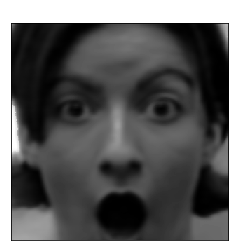

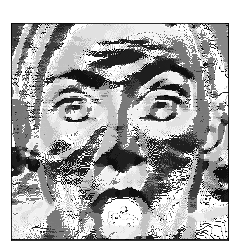

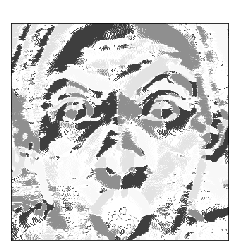

In [485]:
img = cv2.imread('images/test2.png', 0) # load image as grayscale
img = preprocess(img) # apply equalizeHist and bilateral filter
img = cropFace(img) # extract face

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.setp(plt.title('Original preprocessed'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

lbp = local_binary_pattern(img, 8, 1, 'default')
plt.imshow(lbp, cmap='gray', vmin=0, vmax=255)
plt.setp(plt.title('LBP'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

res = hvnLBPWithoutBorders(img)
# print(res)
# norm = cv2.normalize(res, None, 0, 150, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(res, cmap='gray', vmin=0, vmax=255)
plt.setp(plt.title('hvnLBP'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

In [280]:
res[res==41]

array([], dtype=int64)